# Diffusion models

In [1]:
%load_ext autoreload
%autoreload 2

### - Required imports

In [2]:
import torch
import sys

from pathlib import Path
from matplotlib import pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

project_root = Path().absolute().parent
sys.path.append(str(project_root))
project_root

PosixPath('/home/smyth/DiffusionArcade')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n\n")

if device.type == "cuda":
    !nvidia-smi

Using device: cuda


Sat May 17 16:25:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   37C    P0              24W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----

In [4]:
from src.utils import login_huggingface, load_config, show_images, make_grid

login_huggingface()

### - Dataset

In [95]:
dataset = load_dataset(
    "DiffusionArcade/Pong",
    data_dir="images/damian_screens_01",
    split="train"
)

Resolving data files:   0%|          | 0/9666 [00:00<?, ?it/s]

metadata.csv:   0%|          | 0.00/325k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [90]:
actions = load_dataset(
    "DiffusionArcade/Pong",
    data_files="2025‑05‑15_20‑17‑57.csv",
    names = ['file','action'],
    split="train",
)

Generating train split: 0 examples [00:00, ? examples/s]

In [99]:
dataset[2]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x64>,
 'label': '4501_40',
 'action': 1}

In [25]:
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

### Visualizing dataset

In [26]:
image_size = 64
batch_size = 64

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),   # Resize to square
    transforms.Grayscale(num_output_channels=1),   # → single‐channel “L” image
    transforms.ToTensor(),                         # → tensor in [0,1], shape = [1,H,W]
    transforms.Normalize([0.5], [0.5]),            # → tensor in [−1,1]
])


def transform(examples):
    imgs = [preprocess(img) for img in examples["image"]]
    return {"image": imgs}

train_dataset.set_transform(transform)
val_dataset.set_transform(transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)

X shape: torch.Size([8, 1, 64, 64])
Batch of images in training dataset:


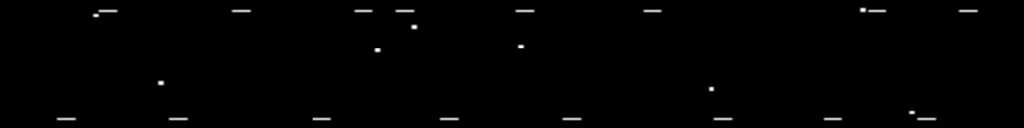

In [27]:
train_batch_images = next(iter(train_dataloader))["image"].to(device)[:8]
print("X shape:", train_batch_images.shape)

print('Batch of images in training dataset:')
show_images(train_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

X shape: torch.Size([8, 1, 64, 64])
Batch of images in validation dataset:


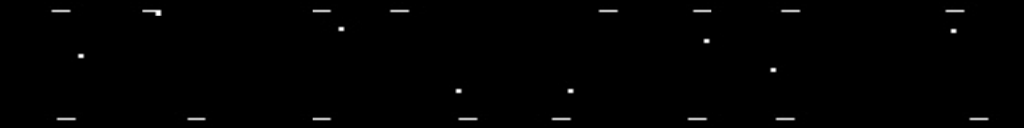

In [28]:
val_batch_images = next(iter(val_dataloader))["image"].to(device)[:8]
print("X shape:", val_batch_images.shape)

print('Batch of images in validation dataset:')
show_images(val_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

## - Forward diffusion process

In [27]:
from diffusers import DDPMScheduler

timesteps = 1000

schedulers = {
    "cosine": DDPMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="squaredcos_cap_v2"
    ),
    "linear": DDPMScheduler(
        num_train_timesteps=timesteps,
        beta_schedule="linear"
    ),
}

The forward diffusion process progressively adds noise to the original image $\mathbf{x}_0$ as timestep $t$ increases.

The process is defined by the re-parameterization formula:

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
    = \mathcal{N}\!\bigl(
        \mathbf{x}_t;\,
        \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\,
        (1 - \bar{\alpha}_t)\,\mathbf{I}
      \bigr)
$$

where:

* $\mathbf{x}_t$ — noisy image at timestep $t$  
* $\sqrt{\bar{\alpha}_t}$ — scales down the original image  
* $1-\bar{\alpha}_t$ — variance of the added Gaussian noise

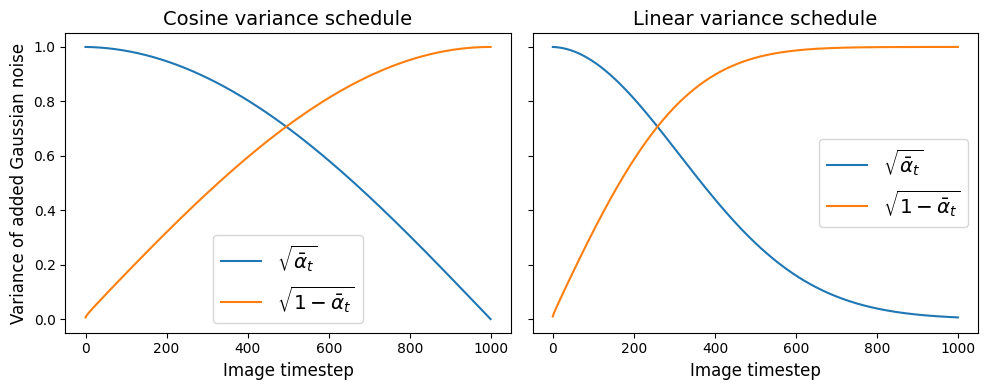

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (name, sched) in zip(axes, schedulers.items()):
    alphas_cumprod = sched.alphas_cumprod.cpu()
    
    ax.plot(
        alphas_cumprod ** 0.5,
        label=r"$\sqrt{\bar{\alpha}_t}$"
    )
    ax.plot(
        (1 - alphas_cumprod) ** 0.5,
        label=r"$\sqrt{1 - \bar{\alpha}_t}$"
    )
    ax.set_title(f"{name.capitalize()} variance schedule", fontsize=14)
    ax.set_xlabel("Image timestep", fontsize=12)
    ax.legend(fontsize="x-large")
    
axes[0].set_ylabel("Variance of added Gaussian noise", fontsize=12)

plt.tight_layout()
plt.show()

The more time steps, the more noise is added to the original image $\mathbf{x}_0$

In [29]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

The following images demonstrate the progressive addition of noise to the original image $\mathbf{x}_0$ across different timesteps. The sequence shows a gradual transition from minimal noise in the initial images to almost complete noise in the final image.

Noisy X shape torch.Size([8, 1, 64, 64])


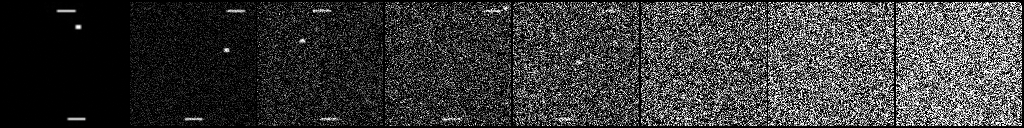

In [30]:
noise = torch.randn_like(train_batch_images) # same shape as xb: [Batch size, Channels, Height, Width]

noisy_train_batch_images = schedulers["cosine"].add_noise(train_batch_images, noise, timesteps)
print("Noisy X shape", train_batch_images.shape)
show_images(noisy_train_batch_images).resize((8 * image_size, image_size), resample=Image.NEAREST)

## - Diffusion model to generates Pong images

#### Training loop

In [17]:
from src.diffusion.model import DiffusionModel

In [24]:
from src.diffusion.model import DiffusionModel
from src.utils import get_formatted_run_name

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size=config['training_images']['image_size']
in_channels=config['training_images']['in_channels']
out_channels=config['training_images']['out_channels']
timesteps = config['training_images']['timesteps']
beta_schedule=config['training_images']['beta_schedule']
action_embedding_size=config['training_images']['action_embedding_size']
num_actions=config['training_images']['num_actions']


model = DiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,
)

NameError: name 'DiffusionModel' is not defined

In [25]:
epochs = config["training_images"]["epochs"]
lr = config["training_images"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": get_formatted_run_name(run_name=config['wandb']['run_name'], model_type=""),
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

Epoch 1/30:   0%|                                                                                                                                                                       | 0/121 [00:00<?, ?it/s]/home/smyth/miniconda3/envs/diffusion_arcade/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/30:   0%|                                                                                                                                                                       | 0/121 [00:00<?, ?it/s]


TypeError: UNet2DConditionModel.forward() missing 1 required positional argument: 'encoder_hidden_states'

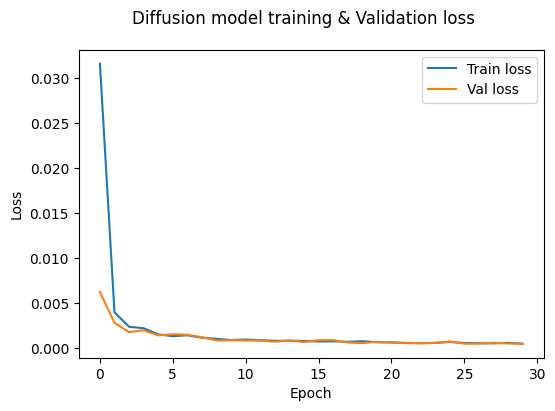

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion model training & Validation loss")

ax.plot(train_losses, label="Train loss")
ax.plot(val_losses, label="Val loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

In [37]:
# Optionally save the model
torch.save(model.model.state_dict(), "../models/diffusion_unet.pth")

#### Testing the diffusion model: Pong image generation

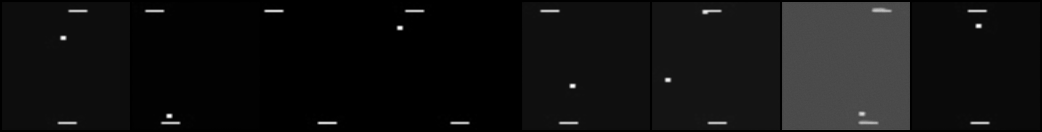

In [22]:
n_images = 8
n_channels = 1
num_inference_steps = 1000

sample = model.generate(n_images, n_channels, num_inference_steps)

show_images(sample)

In [38]:
model.save(
    output_dir=config["training_images"]["output_dir"],
    hf_org=config["training_images"]["hf_org"],
    model_name=config["training_images"]["model_name"]
)

Model saved successfully to models/diffusion_unet.pth!
Pushing model to Hugging Face repo: DiffusionArcade/diffusion_unet...


diffusion_unet.pth:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Model pushed to Hugging Face: https://huggingface.co/DiffusionArcade/diffusion_unet/blob/main/diffusion_unet.pth


## - Using VAE to generate latent representations (z)

In [149]:
dataset = load_dataset("DiffusionArcade/Pong", split="train")

split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset   = split_datasets["test"]

Resolving data files:   0%|          | 0/27239 [00:00<?, ?it/s]

#### 1. Testing VAE: encoding Pong frames and decoding them to reconstruct the original images

In [150]:
from src.diffusion.vae import VAE
from src.utils import load_config

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = config['training_latents']['image_size']
vae_name = config['training_latents']['vae_name']

vae = VAE(vae_name=vae_name, device=device, image_size=image_size)

#### 1.1. Encoding Pong images

In [151]:
batch_size = config['training_latents']['batch_size']

train_dataset.set_transform(vae.encode_batch)
val_dataset.set_transform(vae.encode_batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [152]:
for batch in train_dataloader:
    print('Encoded images -> latents shape:', batch['latents'].shape)
    break

Encoded images -> latents shape: torch.Size([64, 4, 8, 8])


#### 1.2. Checking noise added by the cosine scheduler

X shape: torch.Size([8, 4, 8, 8])
Batch of latents in training dataset:


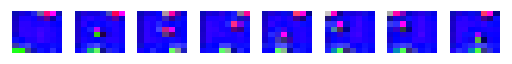

In [153]:
train_batch_latents = next(iter(train_dataloader))["latents"].to(device)[:8]
print("X shape:", train_batch_latents.shape)

print('Batch of latents in training dataset:')
show_images(train_batch_latents).resize((8 * image_size, image_size), resample=Image.NEAREST)

Noisy X shape torch.Size([8, 4, 8, 8])


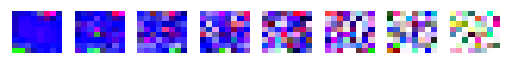

In [154]:
noise = torch.randn_like(train_batch_latents) # same shape as xb: [Batch size, Channels, Height, Width]

timesteps = torch.linspace(0, 999, 8).long().to(device)

noisy_train_batch_latents = schedulers["cosine"].add_noise(train_batch_latents, noise, timesteps)

print("Noisy X shape", noisy_train_batch_latents.shape)
show_images(noisy_train_batch_latents).resize((8 * image_size, image_size), resample=Image.NEAREST)

In [155]:
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')

#### 1.3. Decoding latent representations

Decoded latents batch: torch.Size([8, 3, 64, 64])


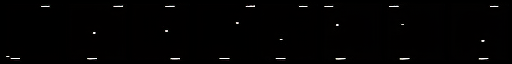

In [156]:
batch = next(iter(train_dataloader))
latents = batch["latents"]               # shape [B, C, h, w]

decoded_tensor = vae.decode_latents(latents)[:8]
print(f"Decoded latents batch:", decoded_tensor.shape)

show_images(decoded_tensor).resize((8 * image_size, image_size), resample=Image.NEAREST)

## - Using VAE latent representations in the diffusion model

In [163]:
from src.diffusion.model import LatentDiffusionModel
from src.diffusion.vae import VAE
from src.utils import login_huggingface, load_config, get_formatted_run_name

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

login_huggingface()

#### Step 1: Load the VAE

In [164]:
vae_name = config["training_latents"]["vae_name"]
image_size = config['training_latents']['image_size']

vae = VAE(vae_name=vae_name, device=device, image_size=image_size)

#### Step 2: Loading the dataset and encoding images to generate latents

In [165]:
print("Loading the dataset...")
batch_size = config["training_latents"]["batch_size"]

dataset = load_dataset("DiffusionArcade/Pong", split="train")

split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets["train"]
val_dataset = split_datasets["test"]

print("Encoding images...")
train_dataset.set_transform(vae.encode_batch)
val_dataset.set_transform(vae.encode_batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Latent representations generated successfully!")

Loading the dataset...


Resolving data files:   0%|          | 0/27239 [00:00<?, ?it/s]

Encoding images...
Latent representations generated successfully!


In [166]:
for batch in train_dataloader:
    print("Shape of a batch of latent representations:", batch["latents"].shape) # This should be [B, C, H, W]
    break

Shape of a batch of latent representations: torch.Size([64, 4, 8, 8])


#### Step 3: Training the diffusion model with latent representations

In [167]:
latent_channels = vae.latent_channels
latent_size = vae.latent_size
scheduler = config["training_latents"]["scheduler"]

model = LatentDiffusionModel(
    latent_channels=latent_channels,
    latent_size=latent_size,
    noise_scheduler=scheduler
)

In [ ]:
epochs = config["training_latents"]["epochs"]

lr = config["training_latents"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": get_formatted_run_name(run_name=config['wandb']['run_name'], model_type="latent"),
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

In [13]:
model

#### (Optional) Step 4: Save the model

In [16]:
model.save(
    output_dir=config["training_latents"]["output_dir"],
    hf_org=config["training_latents"]["hf_org"],
    model_name=config["training_latents"]["model_name"]
)

Model saved successfully to models/latent_diffusion_unet.pth!
Pushing model to Hugging Face repo: DiffusionArcade/latent_diffusion_unet...


latent_diffusion_unet.pth:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Model pushed to Hugging Face: https://huggingface.co/DiffusionArcade/latent_diffusion_unet/blob/main/latent_diffusion_unet.pth


In [62]:
# to load the locally saved model, uncomment the following lines
model = LatentDiffusionModel()
model.model.load_state_dict(torch.load("../models/latent_diffusion_unet.pth")) # or update to the correct path
model.model.eval()
print('Loaded model!')

Loaded model!


#### Step 5: Evaluate the model

Latent representations shape: torch.Size([8, 4, 16, 16])
Decoded tensor shape: torch.Size([8, 3, 128, 128])


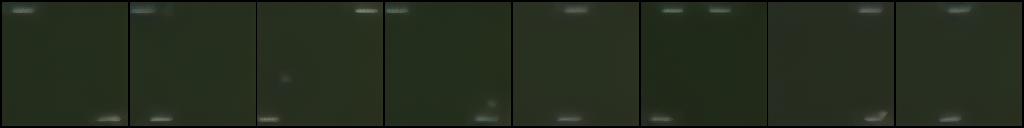

In [66]:
n_images = 8

# num_inference_steps must be 1000 when using the DDPM scheduler. Otherwise, this variable can have different values (DDIM scheduler)
num_inference_steps = 1000

latents = model.generate_latents(n_images, num_inference_steps)
print("Latent representations shape:", latents.shape)

decoded_tensor = vae.decode_latents(latents)
print("Decoded tensor shape:", decoded_tensor.shape)

show_images(decoded_tensor).resize((8 * 128, 128), resample=Image.NEAREST)

### - Adding context to the difussion model

#### Important: The best model we achieved was using images instead of latent representations

In [145]:
import matplotlib.pyplot as plt
import random
import numpy as np

from pathlib import Path
from src.utils import login_huggingface, load_config, show_images, make_grid
from datasets import load_dataset
from torch.utils.data import random_split, DataLoader

from src.diffusion.data_preprocessing import ContextFrameDataset
from src.diffusion.model import ConditionedDiffusionModel
from src.utils import get_formatted_run_name

login_huggingface()

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 1. Generating context dataset

In [146]:
raw_dataset = load_dataset("DiffusionArcade/Pong", split="train")

image_size = config['training_conditioned_images']['image_size']
in_channels=config['training_conditioned_images']['in_channels']
context_length = in_channels - 1

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

context_dataset = ContextFrameDataset(raw_dataset, context_length=context_length, step=2, transform=preprocess)

Resolving data files:   0%|          | 0/27239 [00:00<?, ?it/s]

In [147]:
batch_size = config['training_conditioned_images']['batch_size']

train_ds, val_ds = context_dataset.train_val_split(val_ratio=0.2, random_seed=42)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

In [148]:
for (context_frames, actions), next_frame in train_dataloader:
    print("Context frame shape:", context_frames.shape)
    print("Actions shape:", actions.shape)
    print("Next frame:", next_frame.shape)
    break

Context frame shape: torch.Size([64, 4, 64, 64])
Actions shape: torch.Size([64, 4])
Next frame: torch.Size([64, 64, 64])


#### 2. Display context dataset

Batch shape: frames=torch.Size([64, 4, 64, 64]), actions=torch.Size([64, 4]), next=torch.Size([64, 64, 64])


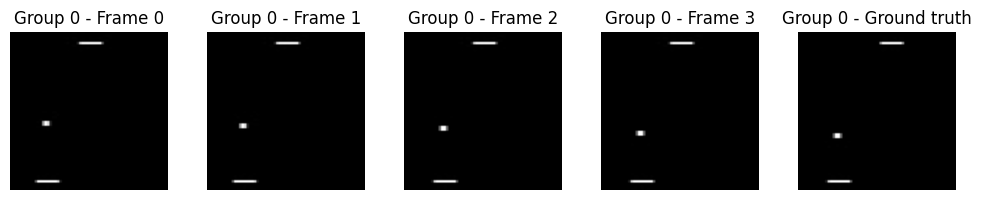

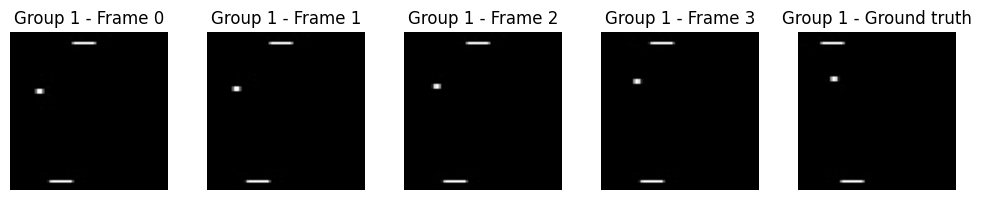

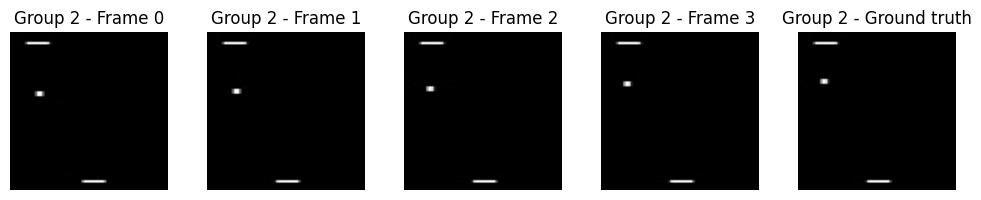

In [149]:
def inspect_batch(dataloader, num_groups: int=3):
    """
    Iterate over a batch and plot a few groups of context frames and their ground truth.

    Args:
        dataloader (DataLoader): sampler providing batches of ((C,H,W), actions), (H,W)
        num_groups (int): how many groups (batch elements) to display
    """
    (frames, actions), next_frames = next(iter(dataloader))
    B, C, H, W = frames.shape  # e.g. (64, 4, 64, 64)
    print(f"Batch shape: frames={frames.shape}, actions={actions.shape}, next={next_frames.shape}")

    # For first num_groups, plot context frames and ground truth
    for i in range(min(num_groups, B)):
        fig, axes = plt.subplots(1, C + 1, figsize=(2*(C+1), 2))

        for c in range(C):
            axes[c].imshow(frames[i, c].cpu(), cmap='gray')
            axes[c].set_title(f"Group {i} - Frame {c}")
            axes[c].axis('off')

        axes[-1].imshow(next_frames[i].cpu(), cmap='gray')
        axes[-1].set_title(f"Group {i} - Ground truth")
        axes[-1].axis('off')

        plt.tight_layout()
        plt.show()

inspect_batch(train_dataloader, num_groups=3)

### 3. Train diffusion model with context frames

In [162]:
image_size=config['training_conditioned_images']['image_size']
in_channels=config['training_conditioned_images']['in_channels']
out_channels=config['training_conditioned_images']['out_channels']
timesteps = config['training_conditioned_images']['timesteps']
beta_schedule=config['training_conditioned_images']['beta_schedule']

model = ConditionedDiffusionModel(
    image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,
)

In [163]:
epochs = config["training_conditioned_images"]["epochs"]
lr = config["training_conditioned_images"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": get_formatted_run_name(run_name=config['wandb']['run_name'], model_type="conditioned"),
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=epochs,
    lr=lr,
    wandb_config=wandb_cfg,
)

train/loss,▇▇█▇▇▇▆▆▆▆▆▅▅▄▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train/loss,0.03944


Epoch 1/5: 100%|████████████████████████████████████████████████| 169/169 [01:38<00:00,  1.72it/s, loss=0.011]


Epoch [1/5] Train Loss: 0.0504 Val Loss: 0.0064 LR: 1.88e-04


Epoch 2/5: 100%|██████████████████████████████████████████████| 169/169 [01:38<00:00,  1.72it/s, loss=0.00423]


Epoch [2/5] Train Loss: 0.0051 Val Loss: 0.0040 LR: 1.40e-04


Epoch 3/5: 100%|██████████████████████████████████████████████| 169/169 [01:38<00:00,  1.71it/s, loss=0.00267]


Epoch [3/5] Train Loss: 0.0039 Val Loss: 0.0034 LR: 7.51e-05


Epoch 4/5: 100%|██████████████████████████████████████████████| 169/169 [01:38<00:00,  1.71it/s, loss=0.00344]


Epoch [4/5] Train Loss: 0.0031 Val Loss: 0.0029 LR: 2.09e-05


Epoch 5/5: 100%|██████████████████████████████████████████████| 169/169 [01:38<00:00,  1.72it/s, loss=0.00363]


Epoch [5/5] Train Loss: 0.0028 Val Loss: 0.0030 LR: 5.41e-08


epoch,▁▃▅▆█
epoch/train_loss,█▁▁▁▁
epoch/val_loss,█▃▂▁▁
train/loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5
epoch/train_loss,0.00285
epoch/val_loss,0.00295
train/loss,0.00363


In [154]:
model.save(
    output_dir=config["training_conditioned_images"]["output_dir"],
    hf_org=config["training_conditioned_images"]["hf_org"],
    model_name=config["training_conditioned_images"]["model_name"]
)

Model saved successfully to models/conditioned_diffusion_unet.pth!
Pushing model to Hugging Face repo: DiffusionArcade/conditioned_diffusion_unet...


conditioned_diffusion_unet.pth:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Model pushed to Hugging Face: https://huggingface.co/DiffusionArcade/conditioned_diffusion_unet/blob/main/conditioned_diffusion_unet.pth


## Action Conditioning

In [38]:
from src.diffusion.model import ConditionalDiffusion

config = load_config("../config.yaml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size=config['training_images']['image_size']
in_channels=config['training_images']['in_channels']
out_channels=config['training_images']['out_channels']
timesteps = config['training_images']['timesteps']
beta_schedule=config['training_images']['beta_schedule']
action_embedding_size=config['training_images']['action_embedding_size']
num_actions=config['training_images']['num_actions']

model = ConditionalDiffusion(image_size=image_size,
    in_channels=in_channels,
    out_channels=out_channels,
    device=device,
    timesteps=timesteps,
    beta_schedule=beta_schedule,           
    action_embedding_size=action_embedding_size,
    num_actions=num_actions
)


epochs = config["training_images"]["epochs"]
lr = config["training_images"]["learning_rate"]
wandb_cfg = {
    "project": config["wandb"]["project"],
    "entity": config["wandb"]["entity"],
    "name": config["wandb"]["run_name"],
    "config": config
}

train_losses, val_losses = model.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=10,
    lr=lr,
    wandb_config=wandb_cfg,                             
)

Action embedding size:	 256


epoch,▁█
epoch/train_loss,█▁
epoch/val_loss,█▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,2
epoch/train_loss,0.0041
epoch/val_loss,0.00282
train/loss,0.00316


Epoch 1/10: 100%|█████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.0069]


Epoch [1/10] Train Loss: 0.0362 Val Loss: 0.0065


Epoch 2/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00309]


Epoch [2/10] Train Loss: 0.0045 Val Loss: 0.0035


Epoch 3/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00297]


Epoch [3/10] Train Loss: 0.0028 Val Loss: 0.0022


Epoch 4/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00132]


Epoch [4/10] Train Loss: 0.0020 Val Loss: 0.0021


Epoch 5/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00138]


Epoch [5/10] Train Loss: 0.0016 Val Loss: 0.0013


Epoch 6/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00126]


Epoch [6/10] Train Loss: 0.0016 Val Loss: 0.0016


Epoch 7/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00122]


Epoch [7/10] Train Loss: 0.0014 Val Loss: 0.0012


Epoch 8/10: 100%|████████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00105]


Epoch [8/10] Train Loss: 0.0012 Val Loss: 0.0010


Epoch 9/10: 100%|███████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.000989]


Epoch [9/10] Train Loss: 0.0014 Val Loss: 0.0012


Epoch 10/10: 100%|███████████████████████████| 120/120 [02:41<00:00,  1.35s/it, loss=0.00107]


Epoch [10/10] Train Loss: 0.0013 Val Loss: 0.0010


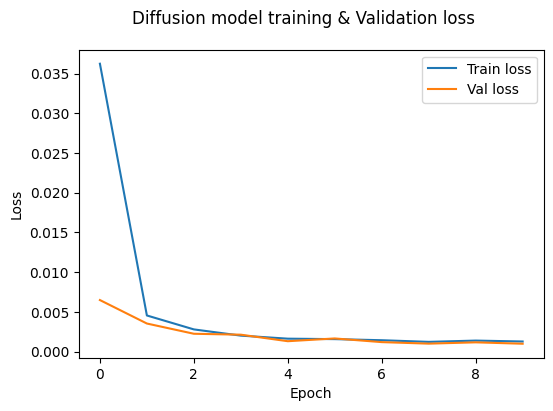

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Diffusion model training & Validation loss")

ax.plot(train_losses, label="Train loss")
ax.plot(val_losses, label="Val loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

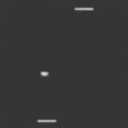

In [81]:
n_images = 8
n_channels = 1
num_inference_steps = 100

action = 2

sample = model.generate(1, n_channels, num_inference_steps, action)
show_images(sample)

## References

1. **Hugging Face Diffusion Course, Unit 0: Introduction to Diffusion Models**  
   Available online: [https://huggingface.co/learn/diffusion-course/en/unit0/1](https://huggingface.co/learn/diffusion-course/en/unit0/1)

2. **Ho, J., Jain, A., & Abbeel, P.** (2020). *Denoising Diffusion Probabilistic Models*.  
   arXiv preprint arXiv:2006.11239. [PDF](https://arxiv.org/pdf/2006.11239)

3. **Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B.** (2022). *High-Resolution Image Synthesis with Latent Diffusion Models*.  
   arXiv preprint arXiv:2208.11970. [PDF](https://arxiv.org/pdf/2208.11970)
